/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Epoch 1, Loss: 0.6637, AUC: 0.7746, Accuracy: 0.6945
Epoch 2, Loss: 0.5896, AUC: 0.8058, Accuracy: 0.7309
Epoch 3, Loss: 0.5220, AUC: 0.8225, Accuracy: 0.7273
Epoch 4, Loss: 0.5185, AUC: 0.8325, Accuracy: 0.7527
Epoch 5, Loss: 0.4862, AUC: 0.8422, Accuracy: 0.7709
Epoch 6, Loss: 0.4675, AUC: 0.8505, Accuracy: 0.7745
Epoch 7, Loss: 0.4675, AUC: 0.8596, Accuracy: 0.7855
Epoch 8, Loss: 0.4486, AUC: 0.8677, Accuracy: 0.7855
Epoch 9, Loss: 0.4325, AUC: 0.8741, Accuracy: 0.7855
Epoch 10, Loss: 0.4357, AUC: 0.8816, Accuracy: 0.7964
Epoch 11, Loss: 0.4385, AUC: 0.8871, Accuracy: 0.8109
Epoch 12, Loss: 0.4224, AUC: 0.8920, Accuracy: 0.8291
Epoch 13, Loss: 0.4019, AUC: 0.8954, Accuracy: 0.8182
Epoch 14, Loss: 0.4067, AUC: 0.8983, Accuracy: 0.8145
Epoch 15, Loss: 0.3975, AUC: 0.9002, Accuracy: 0.8073
Epoch 16, Loss: 0.3867, AUC: 0.8997, Accuracy: 0.8000
Epoch 17, Loss: 0.3858, AUC: 0.8995, Accuracy: 0.8145
Epoch 18, Loss: 0.3871, AUC: 0.9009, Accuracy: 0.8182
Epoch 19, Loss: 0.3724, AUC: 0.9010, 

<Figure size 600x600 with 0 Axes>

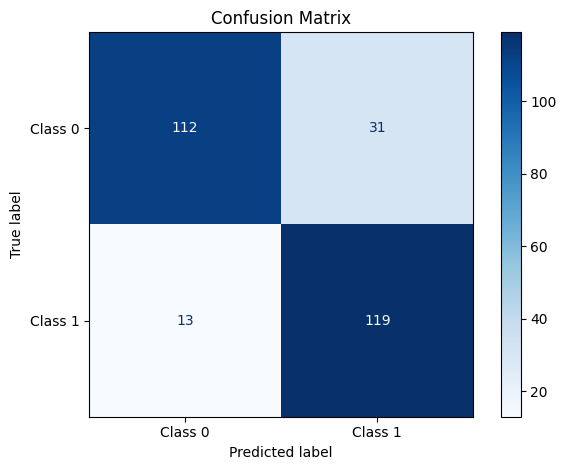

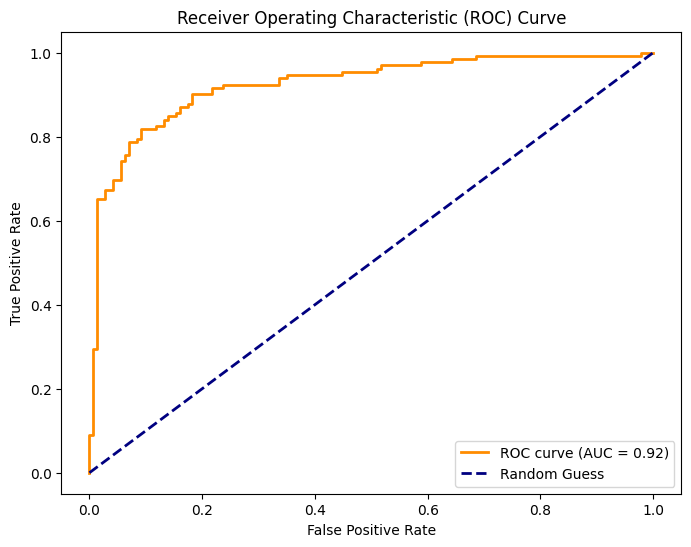

['/content/drive/MyDrive/Halitosis/scaler.pkl']

In [47]:
import pandas as pd
import random
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay

# 1. 데이터 로드 및 전처리
file_path = '/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx'  # 엑셀 파일 경로
data = pd.read_excel(file_path)



# 특징 및 타겟 설정
X = data[['Sex', 'Age', 'Elderly', 'Super_Elderly', 'Xerostomia_subjective', 'UFR', 'SFR', 'pH', 'BufferCapacity',
          'VAS', 'StickySaliva', 'Oralhygiene', 'Calculus', 'O_Stomatitis', 'O_RAU', 'O_Candidiasis', 'O_Periodontitis',
          'O_LichenPlanus', 'O_Sialodochitis', 'O_Glossodynia', 'O_BMS', 'S_Hypertension', 'S_DM', 'S_Hyperlipidemia',
          'S_RenalDiseases', 'S_LiverDiseases', 'S_Rheumatism', 'S_Osteoporosis', 'S_CVD', 'S_TD', 'S_MentalDisorders',
          'S_UrinaryDiseases', 'S_Asthma', 'S_CancerOp', 'NumberofSystmicDiseases', 'M_Hypertension', 'M_DM',
          'M_Osteoporosis', 'M_Hyperlipidemia', 'M_CV', 'M_TD', 'M_GI', 'M_UrinaryDiseases', 'M_Arthritis',
          'M_Rheumatism', 'M_Anxiolytic', 'M_SleepingPills', 'M_Aspirin' ]]  # 입력 특징

y = data['Halitosis_subjective']  # 타겟 레이블


#X = pd.get_dummies(X, columns=['Sex'], drop_first=True)  # Sex 변수 원-핫 인코딩


# SMOTE 적용
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Tensor 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

# 2. 트랜스포머 모델 정의
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.input_layer = nn.Linear(input_dim, 64)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=num_heads, batch_first=True, dropout=0.3  # Dropout 비율 증가
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(p=0.3)  # 추가 Dropout Layer
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.input_layer(x).unsqueeze(1)
        x = self.transformer(x).squeeze(1)
        x = self.dropout(x)  # Dropout 적용
        x = self.output_layer(x)
        return torch.sigmoid(x)



# 손실 함수 변경
criterion = FocalLoss(alpha=1, gamma=2)

# 3. 모델 초기화
model = TransformerModel(input_dim=X_train.shape[1], num_heads=4, num_layers=2)

# Learning Rate Scheduler 추가
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# 클래스 가중치 계산
class_weights = torch.tensor([1.0, len(y_train) / sum(y_train)])
criterion = nn.BCELoss()  # 클래스 가중치 사용

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.0005)


# 4. 학습 및 평가
best_auc = 0
patience = 10
counter = 0

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train).squeeze()
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test).squeeze()
        auc_score = roc_auc_score(y_test.numpy(), test_outputs.numpy())
        predictions = (test_outputs >= 0.5).float()
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")

    # Early Stopping
    if auc_score > best_auc:
        best_auc = auc_score
        counter = 0  # Reset counter
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

# 5. Confusion Matrix 출력
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix 시각화
cm = confusion_matrix(y_test.numpy(), predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix")
plt.tight_layout()  # 추가하여 그래프 표시 문제 해결
plt.show()

from sklearn.metrics import auc as sklearn_auc  # 'auc' 이름 충돌 방지

# ROC Curve 시각화
fpr, tpr, _ = roc_curve(y_test.numpy(), test_outputs.numpy())  # 실제 레이블과 예측 확률
roc_auc = sklearn_auc(fpr, tpr)  # sklearn의 'auc' 함수 명시적 호출

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# 모델 전체 저장
torch.save(model, '/content/drive/MyDrive/Halitosis/halitosis_model.pth')

# 스케일러 저장
joblib.dump(scaler, '/content/drive/MyDrive/Halitosis/scaler.pkl')

In [48]:
# 학습에 사용된 Feature 이름 저장 (학습 시 추가)
feature_columns = [
    'Sex', 'Age', 'Elderly', 'Super_Elderly', 'Xerostomia_subjective', 'UFR', 'SFR', 'pH',
    'BufferCapacity', 'VAS', 'StickySaliva', 'Oralhygiene', 'Calculus', 'O_Stomatitis',
    'O_RAU', 'O_Candidiasis', 'O_Periodontitis', 'O_LichenPlanus', 'O_Sialodochitis',
    'O_Glossodynia', 'O_BMS', 'S_Hypertension', 'S_DM', 'S_Hyperlipidemia', 'S_RenalDiseases',
    'S_LiverDiseases', 'S_Rheumatism', 'S_Osteoporosis', 'S_CVD', 'S_TD', 'S_MentalDisorders',
    'S_UrinaryDiseases', 'S_Asthma', 'S_CancerOp', 'NumberofSystmicDiseases', 'M_Hypertension',
    'M_DM', 'M_Osteoporosis', 'M_Hyperlipidemia', 'M_CV', 'M_TD', 'M_GI', 'M_UrinaryDiseases',
    'M_Arthritis', 'M_Rheumatism', 'M_Anxiolytic', 'M_SleepingPills', 'M_Aspirin'
]

# 학습 시 사용된 Feature 이름을 저장 후 파일로 저장
import joblib
joblib.dump(feature_columns, '/content/drive/MyDrive/Halitosis/feature_columns.pkl')


['/content/drive/MyDrive/Halitosis/feature_columns.pkl']

In [52]:
import torch
import pandas as pd
import joblib

# 모델 로드
loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')
loaded_model.eval()  # 평가 모드

# 저장된 Feature 이름 로드
feature_columns = joblib.load('/content/drive/MyDrive/Halitosis/feature_columns.pkl')

# 외부 입력 데이터 예시
input_data = {
    'Sex': 1,                # Female
    'Age': 30,
    'Elderly': 0,
    'Super_Elderly': 0,
    'Xerostomia_subjective': 1,
    'UFR': 1,
    'SFR': 0.9,
    'pH': 6.2,
    'BufferCapacity': 4,
    'VAS': 5,
    'StickySaliva': 1,
    'Oralhygiene': 1,
    'Calculus': 1,
    'M_Hyperlipidemia': 1,
    'O_Sialodochitis': 1,
}

# 누락된 Feature를 추가하고, 순서를 맞춤
for feature in feature_columns:
    if feature not in input_data:
        input_data[feature] = 0  # 기본값으로 0 설정

# 입력 데이터를 Feature 순서에 맞게 정렬
input_df = pd.DataFrame([input_data])[feature_columns]

# 스케일러 로드 및 데이터 정규화
scaler = joblib.load('/content/drive/MyDrive/Halitosis/scaler.pkl')
scaled_input = scaler.transform(input_df)

# Tensor로 변환
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

# 예측 수행
with torch.no_grad():
    probabilities = loaded_model(input_tensor).squeeze().numpy()
    predicted_label = (probabilities >= 0.5).astype(int)

# 출력
print(f"구취 확률: {probabilities * 100:.2f}%")
print(f"예측: {'구취 있음' if predicted_label == 1 else '구취 없음'}")



구취 확률: 0.67%
예측: 구취 없음


<ipython-input-52-920263553cf4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')


In [56]:
import torch
import pandas as pd
import joblib
import numpy as np

# 모델 및 스케일러 로드
loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')  # 모델 로드
loaded_model.eval()  # 평가 모드 설정
scaler = joblib.load('/content/drive/MyDrive/Halitosis/scaler.pkl')  # 스케일러 로드

# 저장된 Feature 이름 로드
feature_columns = joblib.load('/content/drive/MyDrive/Halitosis/feature_columns.pkl')

# CLI를 통해 사용자 입력 받기
print("구취 예측을 위한 데이터를 입력하세요. (입력하지 않으면 기본값 0으로 설정됩니다)")

input_data = {
    'Sex': int(input("성별 (0: 남성, 1: 여성): ") or 0),
    'Age': int(input("나이: ") or 0),
    'Elderly': int(input("노인 여부 (0: 아님, 1: 노인): ") or 0),
    'Super_Elderly': int(input("고령 여부 (0: 아님, 1: 고령): ") or 0),
    'Xerostomia_subjective': int(input("구강 건조 여부 (0: 없음, 1: 있음): ") or 0),
    'UFR': float(input("비자극 타액 분비율 (UFR): ") or 0.0),
    'SFR': float(input("자극 타액 분비율 (SFR): ") or 0.0),
    'pH': float(input("타액의 pH: ") or 0.0),
    'BufferCapacity': float(input("구강 완충능력: ") or 0.0),
    'VAS': int(input("VAS 점수 (0~10): ") or 0),
    'StickySaliva': int(input("침 끈적임 여부 (0: 없음, 1: 있음): ") or 0),
    'Oralhygiene': int(input("구강 위생 (0: 불량, 1: 양호): ") or 0),
    'Calculus': int(input("치석 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_Stomatitis': int(input("구내염 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_RAU': int(input("구내궤양 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_Candidiasis': int(input("칸디다증 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_Periodontitis': int(input("치주염 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_LichenPlanus': int(input("태선 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_Sialodochitis': int(input("타액선염 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_Glossodynia': int(input("설통증 여부 (0: 없음, 1: 있음): ") or 0),
    #'O_BMS': int(input("구강작열감증후군 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_Hypertension': int(input("고혈압 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_DM': int(input("당뇨병 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_Hyperlipidemia': int(input("고지혈증 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_RenalDiseases': int(input("신장질환 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_LiverDiseases': int(input("간질환 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_Rheumatism': int(input("류마티스 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_Osteoporosis': int(input("골다공증 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_CVD': int(input("심혈관질환 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_TD': int(input("갑상선질환 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_MentalDisorders': int(input("정신질환 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_UrinaryDiseases': int(input("비뇨기질환 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_Asthma': int(input("천식 여부 (0: 없음, 1: 있음): ") or 0),
    #'S_CancerOp': int(input("암 수술 여부 (0: 없음, 1: 있음): ") or 0),
    #'NumberofSystmicDiseases': int(input("전신질환 수: ") or 0),
    #'M_Hypertension': int(input("고혈압 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_DM': int(input("당뇨병 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_Osteoporosis': int(input("골다공증 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_Hyperlipidemia': int(input("고지혈증 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_CV': int(input("심혈관 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_TD': int(input("갑상선 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_GI': int(input("소화기 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_UrinaryDiseases': int(input("비뇨기 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_Arthritis': int(input("관절염 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_Rheumatism': int(input("류마티스 약물 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_Anxiolytic': int(input("항불안제 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_SleepingPills': int(input("수면제 복용 여부 (0: 없음, 1: 있음): ") or 0),
    #'M_Aspirin': int(input("아스피린 복용 여부 (0: 없음, 1: 있음): ") or 0)
}

# 모든 Feature를 포함하도록 기본값 추가
for feature in feature_columns:
    if feature not in input_data:
        input_data[feature] = 0  # 누락된 Feature는 기본값 0으로 설정

# 입력 데이터를 DataFrame으로 변환
input_df = pd.DataFrame([input_data])[feature_columns]  # Feature 순서를 동일하게 정렬

# 데이터 정규화
scaled_input = scaler.transform(input_df)

# Tensor로 변환
input_tensor = torch.tensor(scaled_input, dtype=torch.float32)

# Drop-out 기반 예측 수행
def predict_with_dropout(model, input_tensor, num_samples=10, drop_prob=0.2):
    """
    Drop-out을 적용하여 모델이 예측 수행.
    :param model: 로드된 모델
    :param input_tensor: 입력 데이터
    :param num_samples: 샘플 수
    :param drop_prob: Feature Drop-out 확률
    :return: 평균 예측 확률 및 표준편차
    """
    def apply_feature_dropout(input_tensor, drop_prob=0.2):
        mask = torch.rand(input_tensor.shape) > drop_prob
        return input_tensor * mask  # Drop-out 적용된 입력 데이터

    model.train()  # Drop-out 활성화
    predictions = []
    with torch.no_grad():
        for _ in range(num_samples):
            dropped_input = apply_feature_dropout(input_tensor, drop_prob)
            probabilities = model(dropped_input).squeeze().numpy()
            predictions.append(probabilities)
    mean_prob = np.mean(predictions)
    std_prob = np.std(predictions)
    return mean_prob, std_prob

# Drop-out 기반 예측 수행
mean_prob, std_prob = predict_with_dropout(loaded_model, input_tensor, num_samples=10, drop_prob=0.2)

# 예측 결과 출력
predicted_label = (mean_prob >= 0.5).astype(int)
print(f"\n구취 확률 평균: {mean_prob * 100:.2f}% (표준편차: {std_prob * 100:.2f}%)")
print(f"예측: {'구취 있음' if predicted_label == 1 else '구취 없음'}")


<ipython-input-56-020b9fcbdfeb>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load('/content/drive/MyDrive/Halitosis/halitosis_model.pth')  # 모델 로드


구취 예측을 위한 데이터를 입력하세요. (입력하지 않으면 기본값 0으로 설정됩니다)
성별 (0: 남성, 1: 여성): 0
나이: 58
노인 여부 (0: 아님, 1: 노인): 0
고령 여부 (0: 아님, 1: 고령): 0
구강 건조 여부 (0: 없음, 1: 있음): 1
비자극 타액 분비율 (UFR): 0.01
자극 타액 분비율 (SFR): 1
타액의 pH: 6
구강 완충능력: 12
VAS 점수 (0~10): 0
침 끈적임 여부 (0: 없음, 1: 있음): 0
구강 위생 (0: 불량, 1: 양호): 0
치석 여부 (0: 없음, 1: 있음): 0

구취 확률 평균: 91.51% (표준편차: 13.54%)
예측: 구취 있음
